In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt

import re, os
import unicodedata
import json

import nltk
import nltk.sentiment
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from time import strftime

from wordcloud import WordCloud

from pprint import pprint

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import acquire
import prepare_jag

import spacy
pd.set_option('display.max_colwidth', None)



### Acquire data

We will be using the 1000 labeled notes in `test.csv`

In [2]:
df = prepare_jag.prep_train()

Test, notes, and features loaded.
Merged dataframes
Renamed 'pn_history' column to 'original'
Added a basic clean column lowercaseing and removing special characters
Added stemmed column with tokenized words and stopwords removed
Added lemmatized column with lemmatized words and stopwords removed
Data preparation complete


In [3]:
df.head(1)

id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   

                                                      feature_text  \
0  Family-history-of-MI-OR-Family-history-of-myocardial-infarction   

                         annotation     location  \
0  ['dad with recent heart attcak']  ['696 724']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 original  \
0  HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      clean  \
0  hpi 17yo presents palpitations patient reports 3-4 months intermittent episodes heart beatingpounding chest 2 days ago soccer game episode time chest pressure felt going pass lose conciousness note patient endorses abusing adderall primarily study 1-3 times per week recent soccer game took adderrall night morning game denies shortness breath diaphoresis fevers chills headache fatigue changes sleep changes visionhearing abdominal paun changes bowel urinary habits pmhx none rx uses friends adderrall fhx mom thyroid disease dad recent heart attcak none immunizations date shx freshmen college endorses 3-4 drinks 3 nights week weekends denies tabacco endorses trying marijuana sexually active girlfriend x 1 year uses condoms   

                                                                                                                                                                                                                                                                                           

In [4]:
df.shape

(14300, 11)

---

In [5]:
df.case_num.value_counts().sort_index()

0    1300
1    1300
2    1700
3    1600
4    1000
5    1800
6    1200
7     900
8    1800
9    1700
Name: case_num, dtype: int64

In [6]:
# Look at distribution of cases
cases = pd.concat([df.case_num.value_counts().sort_index(), df.case_num.value_counts(normalize = True)], axis = 1)
cases.columns = ['n', 'percent']
cases

n   percent
0  1300  0.090909
1  1300  0.090909
2  1700  0.118881
3  1600  0.111888
4  1000  0.069930
5  1800  0.125874
6  1200  0.083916
7   900  0.062937
8  1800  0.125874
9  1700  0.118881

<AxesSubplot:ylabel='n'>

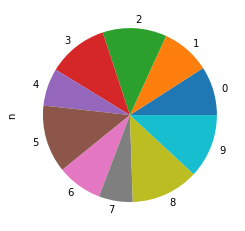

In [7]:
cases.n.plot.pie()

Make word lists by case from lemmatized words



In [8]:
df.head(1)

id  case_num  pn_num  feature_num  \
0  00016_000         0      16            0   

                                                      feature_text  \
0  Family-history-of-MI-OR-Family-history-of-myocardial-infarction   

                         annotation     location  \
0  ['dad with recent heart attcak']  ['696 724']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 original  \
0  HPI: 17yo M presents with palpitations. Patient reports 3-4 months of intermittent episodes of "heart beating/pounding out of my chest." 2 days ago during a soccer game had an episode, but this time had chest pressure and felt as if he were going to pass out (did not lose conciousness). Of note patient endorses abusing adderall, primarily to study (1-3 times per week). Before recent soccer game, took adderrall night before and morning of game. Denies shortness of breath, diaphoresis, fevers, chills, headache, fatigue, changes in sleep, changes in vision/hearing, abdominal paun, changes in bowel or urinary habits. \r\nPMHx: none\r\nRx: uses friends adderrall\r\nFHx: mom with "thyroid disease," dad with recent heart attcak\r\nAll: none\r\nImmunizations: up to date\r\nSHx: Freshmen in college. Endorses 3-4 drinks 3 nights / week (on weekends), denies tabacco, endorses trying marijuana. Sexually active with girlfriend x 1 year, uses condoms   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      clean  \
0  hpi 17yo presents palpitations patient reports 3-4 months intermittent episodes heart beatingpounding chest 2 days ago soccer game episode time chest pressure felt going pass lose conciousness note patient endorses abusing adderall primarily study 1-3 times per week recent soccer game took adderrall night morning game denies shortness breath diaphoresis fevers chills headache fatigue changes sleep changes visionhearing abdominal paun changes bowel urinary habits pmhx none rx uses friends adderrall fhx mom thyroid disease dad recent heart attcak none immunizations date shx freshmen college endorses 3-4 drinks 3 nights week weekends denies tabacco endorses trying marijuana sexually active girlfriend x 1 year uses condoms   

                                                                                                                                                                                                                                                                                           

In [9]:
#Make word lists by case_num_xs from lemmatized words
case0_words = ' '.join(df[df.case_num == 0].lemmatized).split()
case1_words = ' '.join(df[df.case_num == 1].lemmatized).split()
case2_words = ' '.join(df[df.case_num == 2].lemmatized).split()
case3_words = ' '.join(df[df.case_num == 3].lemmatized).split()
case4_words = ' '.join(df[df.case_num == 4].lemmatized).split()
case5_words = ' '.join(df[df.case_num == 5].lemmatized).split()
case6_words = ' '.join(df[df.case_num == 6].lemmatized).split()
case7_words = ' '.join(df[df.case_num == 7].lemmatized).split()
case8_words = ' '.join(df[df.case_num == 8].lemmatized).split()
case9_words = ' '.join(df[df.case_num == 9].lemmatized).split()
all_words = ' '.join(df.lemmatized).split()


In [10]:
# Look at word list lengths
print('Case0 words: '+str(len(case0_words)))
print('Case1 words: '+str(len(case1_words)))
print('Case2 words: '+str(len(case2_words)))
print('Case3 words: '+str(len(case3_words)))
print('Case4 words: '+str(len(case4_words)))
print('Case5 words: '+str(len(case5_words)))
print('Case6 words: '+str(len(case6_words)))
print('Case7 words: '+str(len(case7_words)))
print('Case8 words: '+str(len(case8_words)))
print('Case9 words: '+str(len(case9_words)))
print('All words: '+str(len(all_words)))

Case0 words: 126932
Case1 words: 129428
Case2 words: 178347
Case3 words: 154160
Case4 words: 94310
Case5 words: 176688
Case6 words: 116544
Case7 words: 94770
Case8 words: 185868
Case9 words: 150756
All words: 1407803


In [11]:
# Calculate word frequencies
case0_freq = pd.Series(case0_words).value_counts()
case1_freq = pd.Series(case1_words).value_counts()
case2_freq = pd.Series(case2_words).value_counts()
case3_freq = pd.Series(case3_words).value_counts()
case4_freq = pd.Series(case4_words).value_counts()
case5_freq = pd.Series(case5_words).value_counts()
case6_freq = pd.Series(case6_words).value_counts()
case7_freq = pd.Series(case7_words).value_counts()
case8_freq = pd.Series(case8_words).value_counts()
case9_freq = pd.Series(case9_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

In [12]:
# Look at 20 most common words
word_counts = (pd.concat([all_freq, case0_freq, case1_freq, case2_freq, case3_freq, case4_freq, case5_freq, case6_freq, case7_freq, case8_freq, case9_freq], axis = 1, sort = True)
                .set_axis(['all', 'Case0', 'Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7', 'Case8', 'Case9'], axis = 1, inplace = False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))
word_counts.sort_values(by = 'all', ascending = False).head(20)

all  Case0  Case1  Case2  Case3  Case4  Case5  Case6  Case7  Case8  \
no       43708   3406   4472   5712   5792   2630   6192   2772   3348   4896   
ha       26825   2210   2535   3026   2784   2060   2448   1620   1800   4500   
pain     24651    819   4966   1445   7360    530   1062   4380    792    594   
denies   17621   1807   1482   2176   1600   1570   2052   1572   1089   2250   
none     17377   1638   2119   1207   1904   1330   3618    972   1692    738   
ago      16811   1248   2626   2703    848    630   4122    780   1278   1998   
week     14946    793    988   1428   1888   1540   3780    156    306   2826   
day      13993    871   2015   3366    784    440   1260   1500   1458   1296   
change   12452   1378    520   2278   1040   1250   1530    672   1161   1620   
2        12206    715   1456   2278   2336    430   2088    216   1431    270   
last     12133   1885   1976   2788    736    290   1638    720   1269    576   
year     11205    663    299   3621   1120    330   1890    300    909   1206   
month    10947   1716   1755   1581   1568    210    918    420   2637    108   
-         9646    585    663   1037   1328    570   1116   1044    612   1314   
pmh       9444    858    780   1224   1072    660   1134    792    612   1224   
episode   8836   2626    806    612    352    240   3258     96      0    234   
3         8833    338    208   2380    192    190   1980    192    351   2322   
use       8722   1014    923    799    992    640   1188   1008    702    504   
yo        8306    806    728    952    976    650    900    708    603   1116   
ro        8088    754    676    850    992    640   1026    768    513    900   

         Case9  
no        4488  
ha        3842  
pain      2703  
denies    2023  
none      2159  
ago        578  
week      1241  
day       1003  
change    1003  
2          986  
last       255  
year       867  
month       34  
-         1377  
pmh       1088  
episode    612  
3          680  
use        952  
yo         867  
ro         969

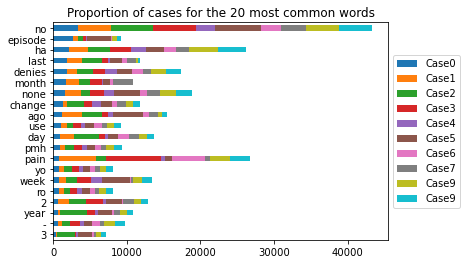

In [13]:
# figure out the percentage of language in words
(word_counts
 .assign(p_case0 = word_counts.Case0 / word_counts['all'],
        p_case1 = word_counts.Case1 / word_counts['all'],
        p_case2 = word_counts.Case2 / word_counts['all'],
        p_case3 = word_counts.Case3 / word_counts['all'],
        p_case4 = word_counts.Case4 / word_counts['all'],
        p_case5 = word_counts.Case5 / word_counts['all'],
        p_case6 = word_counts.Case6 / word_counts['all'],
        p_case7 = word_counts.Case7 / word_counts['all'],
        p_case8 = word_counts.Case8 / word_counts['all'],
        p_case9 = word_counts.Case9 / word_counts['all'])
        
 .sort_values(by = 'all')
 [['Case0', 'Case1', 'Case2', 'Case3', 'Case4', 'Case5', 'Case6', 'Case7', 'Case9', 'Case9']]
 .tail(20)
 .sort_values('Case0')
 .plot.barh(stacked=True))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Proportion of cases for the 20 most common words');

### Look at bigrams by case

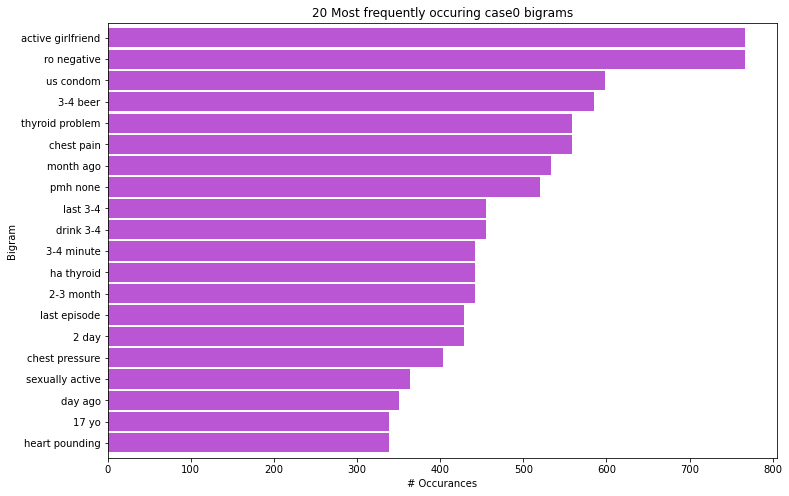

In [14]:
# Calculate Case 0bigrams
case0_bigrams = (pd.Series(nltk.ngrams(case0_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case0 Bigrams
case0_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case0 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case0_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

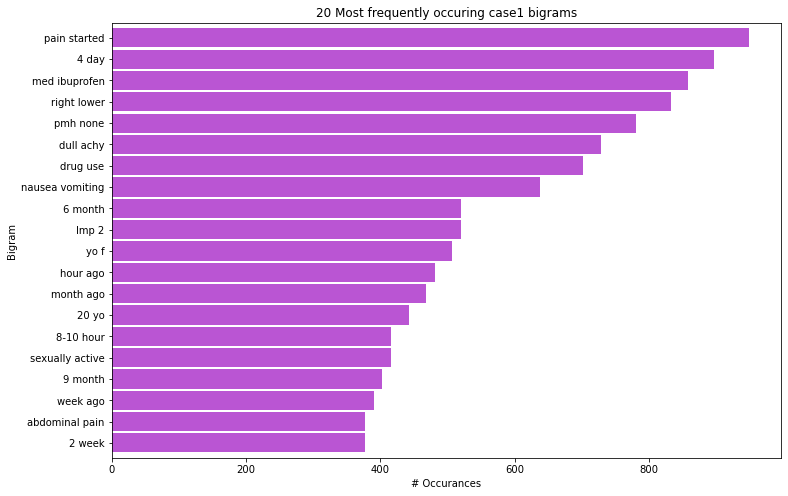

In [15]:
# Calculate Case 1 bigrams
case1_bigrams = (pd.Series(nltk.ngrams(case1_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case1 Bigrams
case1_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case1 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case1_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

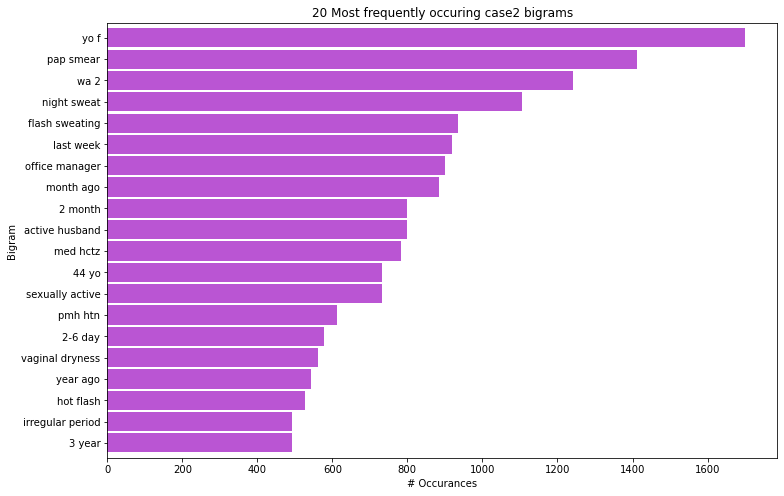

In [16]:
# Calculate Case 2 bigrams
case2_bigrams = (pd.Series(nltk.ngrams(case2_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case2 Bigrams
case2_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case2 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case2_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

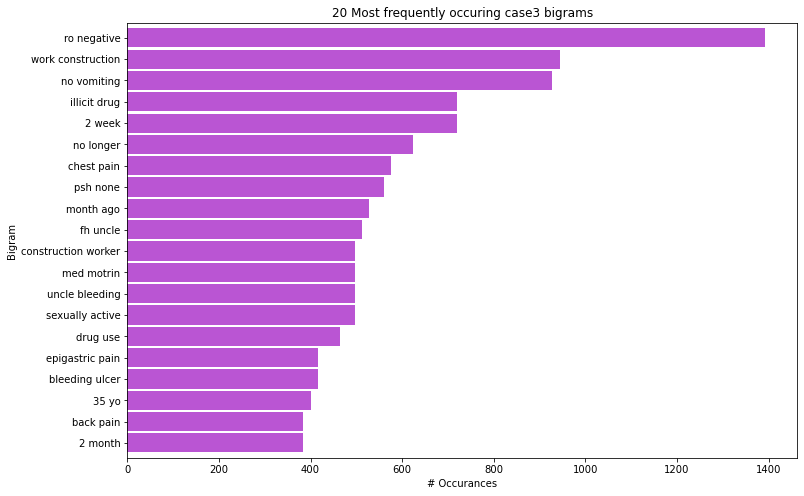

In [17]:
# Calculate Case 3 bigrams
case3_bigrams = (pd.Series(nltk.ngrams(case3_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case3 Bigrams
case3_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case3 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case3_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

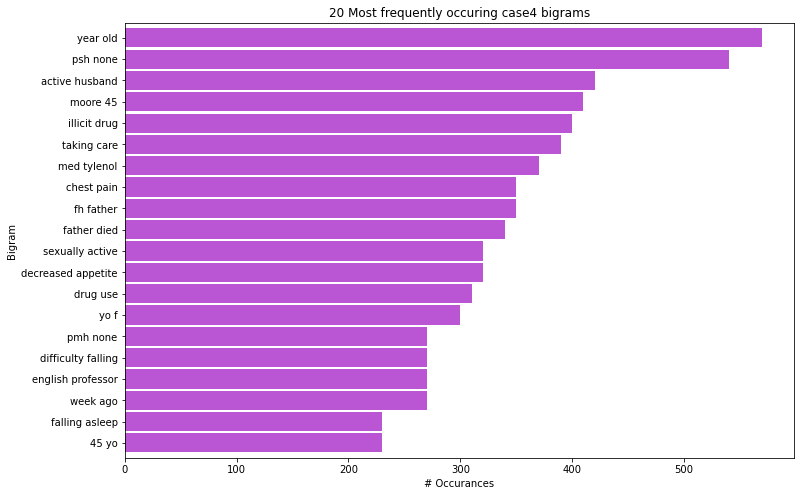

In [18]:
# Calculate Case 4 bigrams
case4_bigrams = (pd.Series(nltk.ngrams(case4_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case4 Bigrams
case4_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case4 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case4_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

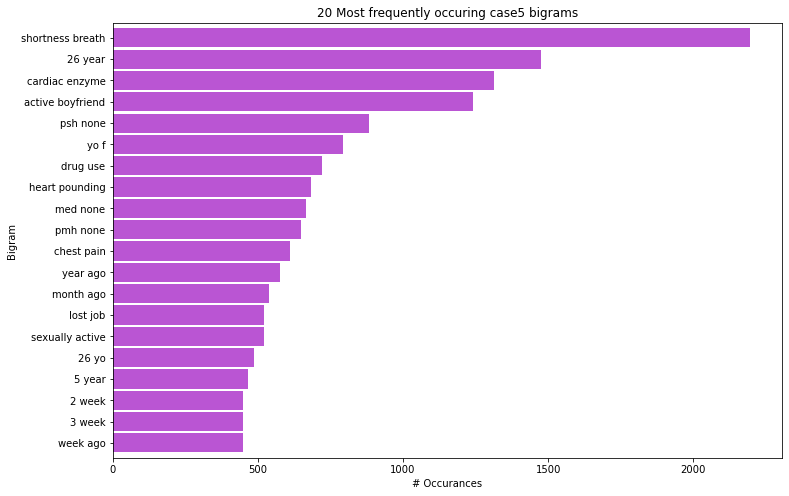

In [19]:
# Calculate Case 5bigrams
case5_bigrams = (pd.Series(nltk.ngrams(case5_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case5 Bigrams
case5_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case5 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case5_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

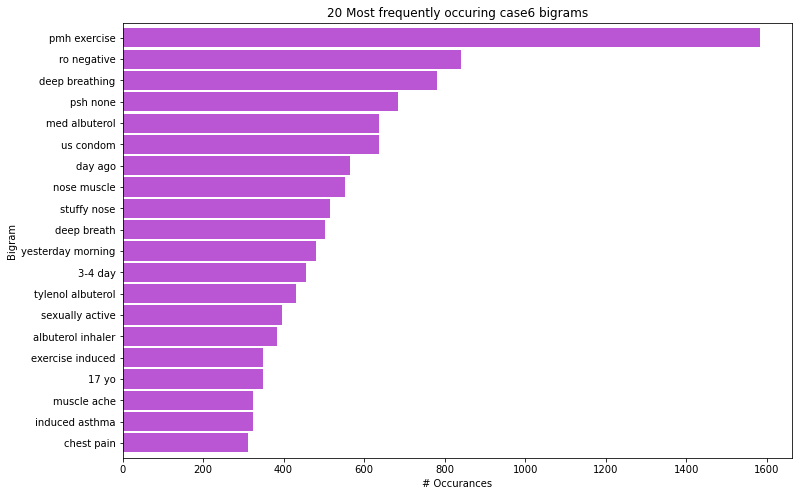

In [20]:
# Calculate Case 6 bigrams
case6_bigrams = (pd.Series(nltk.ngrams(case6_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case6 Bigrams
case6_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case6 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case6_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

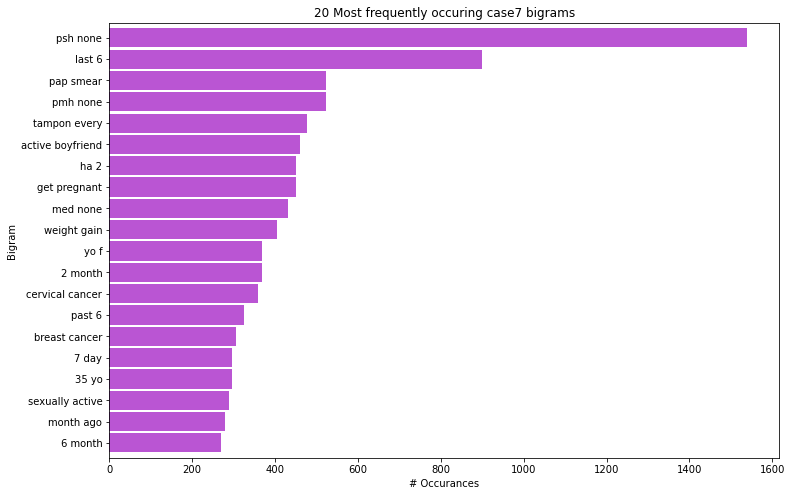

In [21]:
# Calculate Case 7 bigrams
case7_bigrams = (pd.Series(nltk.ngrams(case7_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case7 Bigrams
case7_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case7 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case7_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

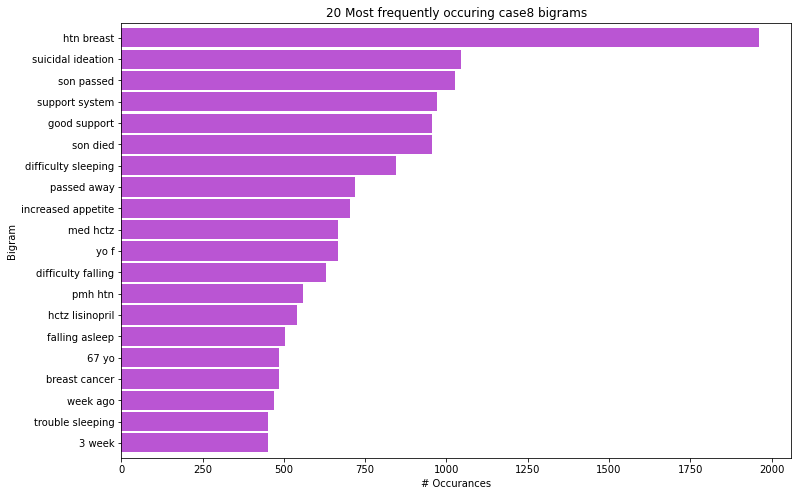

In [22]:
# Calculate Case 8 bigrams
case8_bigrams = (pd.Series(nltk.ngrams(case8_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top case8 Bigrams
case8_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring case8 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = case8_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

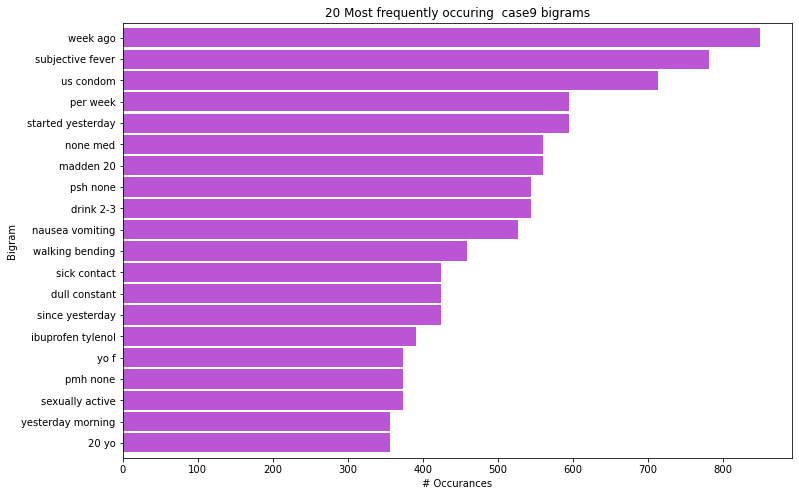

In [23]:
# Calculate Case 9 bigrams
case9_bigrams = (pd.Series(nltk.ngrams( case9_words, 2))
                      .value_counts()
                      .head(20))
# Vizualize top  case9 Bigrams
case9_bigrams.sort_values().plot.barh(color = 'mediumorchid', width=.9, figsize=(12, 8))

plt.title('20 Most frequently occuring  case9 bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels =  case9_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

[ ] Trigrams?

---

### Word Clouds

In [24]:
# Create word clouds for all words and language families
all_cloud = WordCloud(background_color = 'white', height = 1600, width = 800).generate(' '.join(all_words))
case0_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case0_words))
case1_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case1_words))
case2_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case2_words))
case3_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case3_words))
case4_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case4_words))
case5_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case5_words))
case6_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case6_words))
case7_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case7_words))
case8_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case8_words))
case9_cloud = WordCloud(background_color = 'white', height = 800, width = 800).generate(' '.join(case9_words))



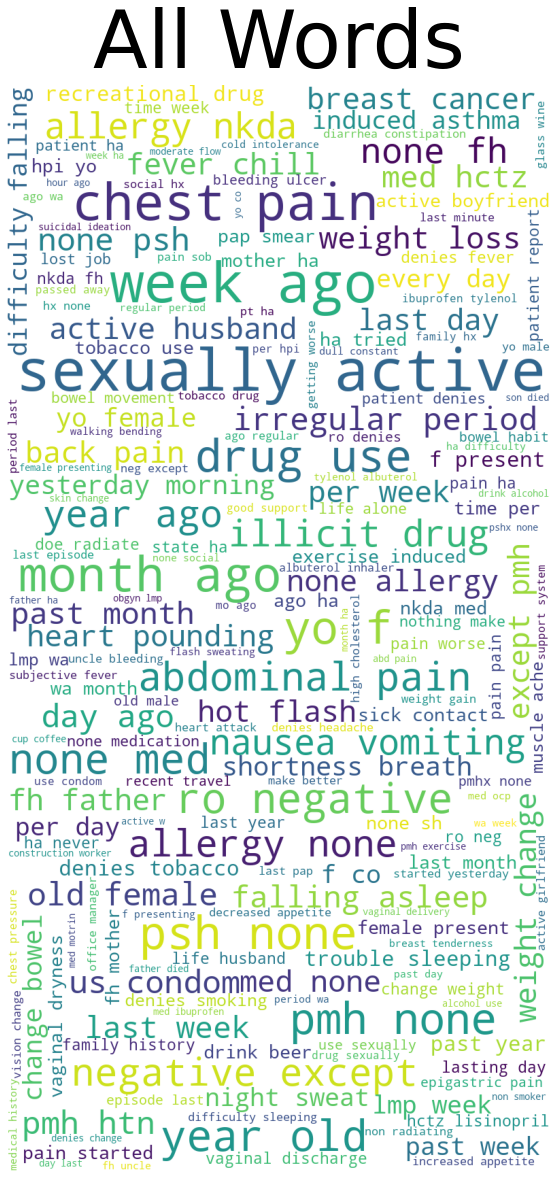

In [25]:
plt.figure(figsize = (10, 20))
plt.imshow(all_cloud);
plt.title('All Words', fontsize=80)
plt.axis('off');

(-0.5, 799.5, 799.5, -0.5)

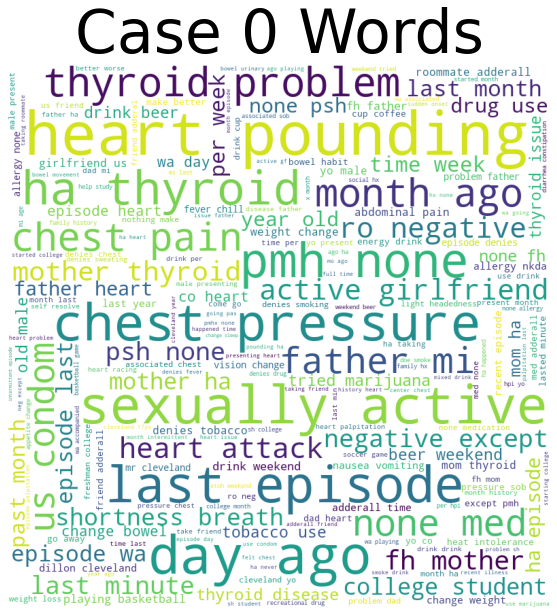

In [26]:
plt.figure(figsize = (10, 10))
plt.imshow(case0_cloud);
plt.title('Case 0 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

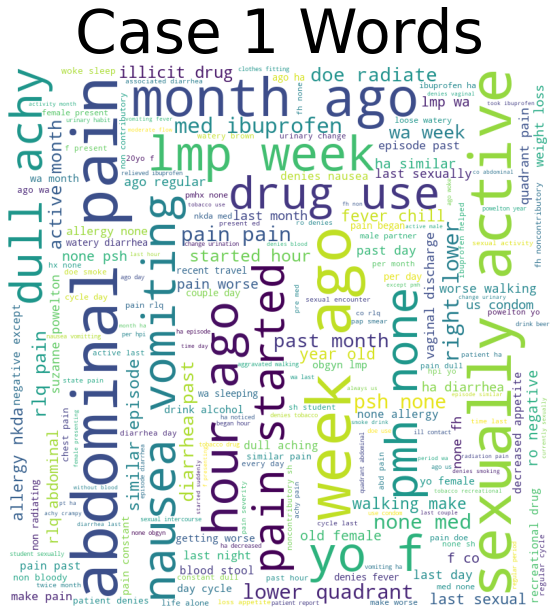

In [27]:
plt.figure(figsize = (10, 10))
plt.imshow(case1_cloud);
plt.title('Case 1 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

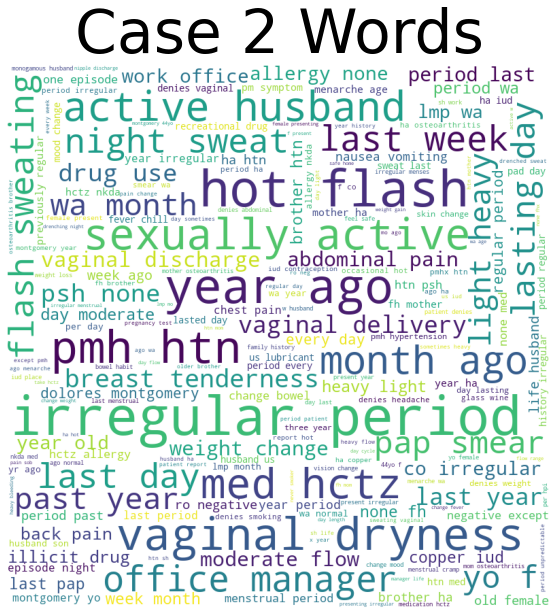

In [28]:
plt.figure(figsize = (10, 10))
plt.imshow(case2_cloud);
plt.title('Case 2 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

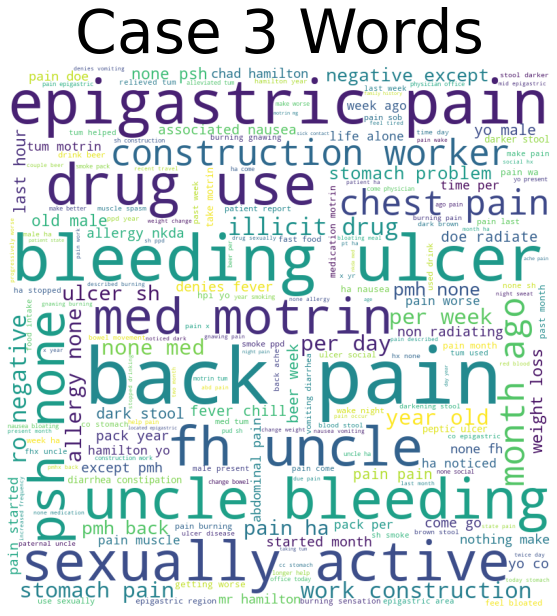

In [29]:
plt.figure(figsize = (10, 10))
plt.imshow(case3_cloud);
plt.title('Case 3 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

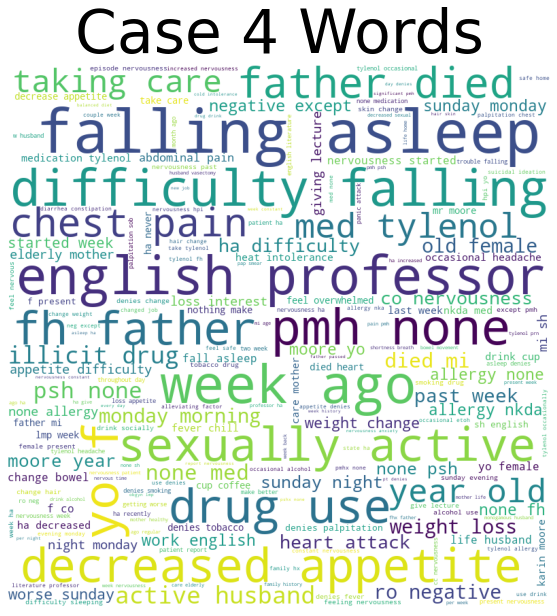

In [30]:
plt.figure(figsize = (10, 10))
plt.imshow(case4_cloud);
plt.title('Case 4 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

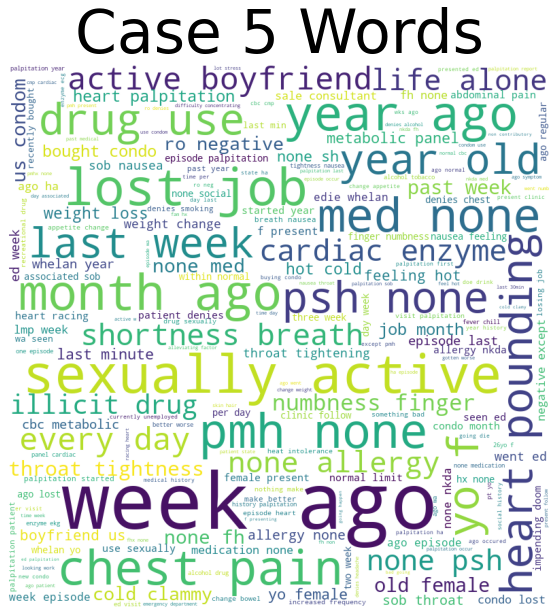

In [31]:
plt.figure(figsize = (10, 10))
plt.imshow(case5_cloud);
plt.title('Case 5 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

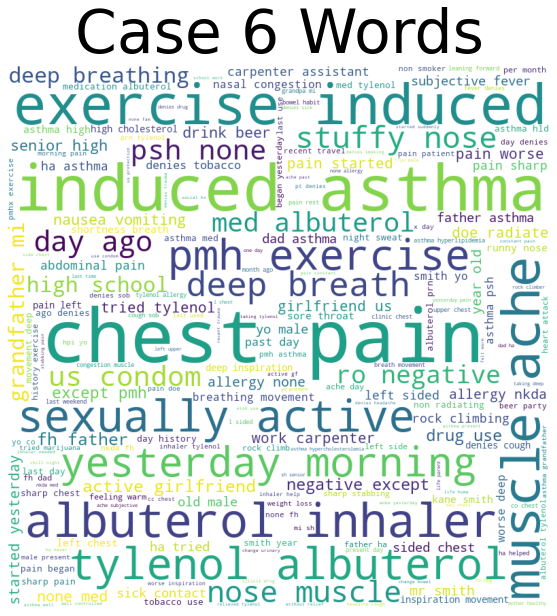

In [32]:
plt.figure(figsize = (10, 10))
plt.imshow(case6_cloud);
plt.title('Case 6 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

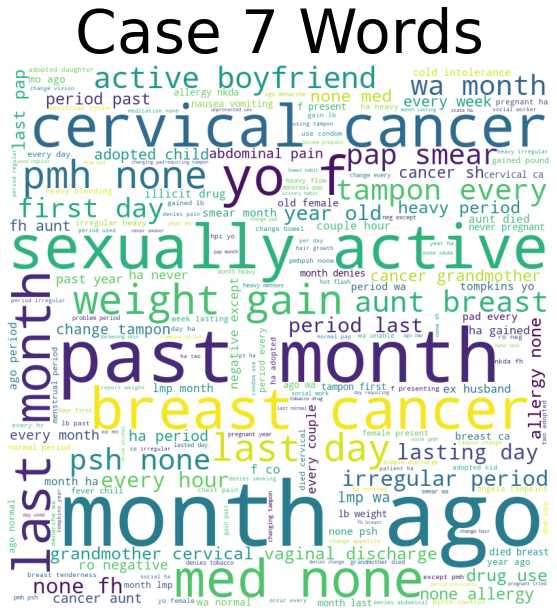

In [33]:
plt.figure(figsize = (10, 10))
plt.imshow(case7_cloud);
plt.title('Case 7 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

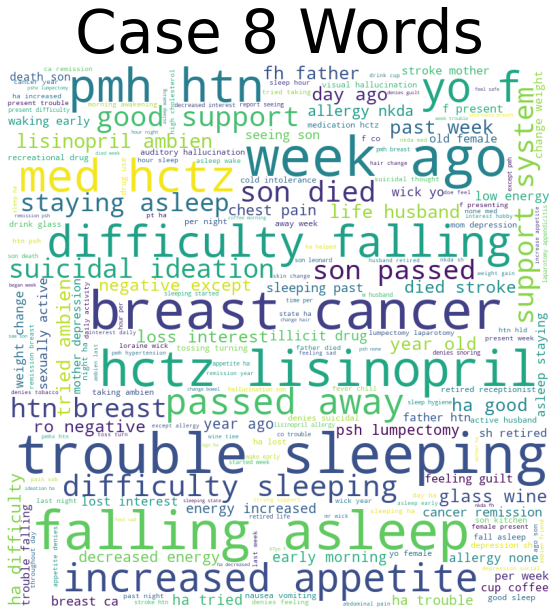

In [34]:
plt.figure(figsize = (10, 10))
plt.imshow(case8_cloud);
plt.title('Case 8 Words', fontsize=60)
plt.axis('off')


(-0.5, 799.5, 799.5, -0.5)

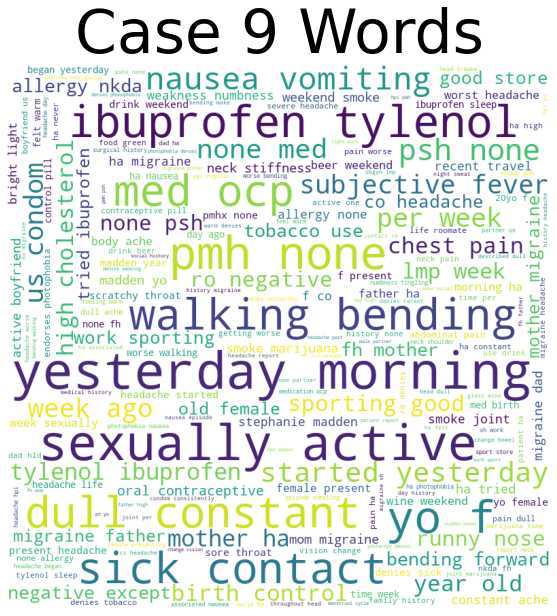

In [35]:
plt.figure(figsize = (10, 10))
plt.imshow(case9_cloud);
plt.title('Case 9 Words', fontsize=60)
plt.axis('off')
